In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50

# Load dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage', shuffle=True, 
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())    

(32, 256, 256, 3)
[0 0 1 0 1 1 0 1 0 1 0 0 1 2 1 2 0 0 0 2 0 1 0 0 0 1 1 1 2 1 1 1]


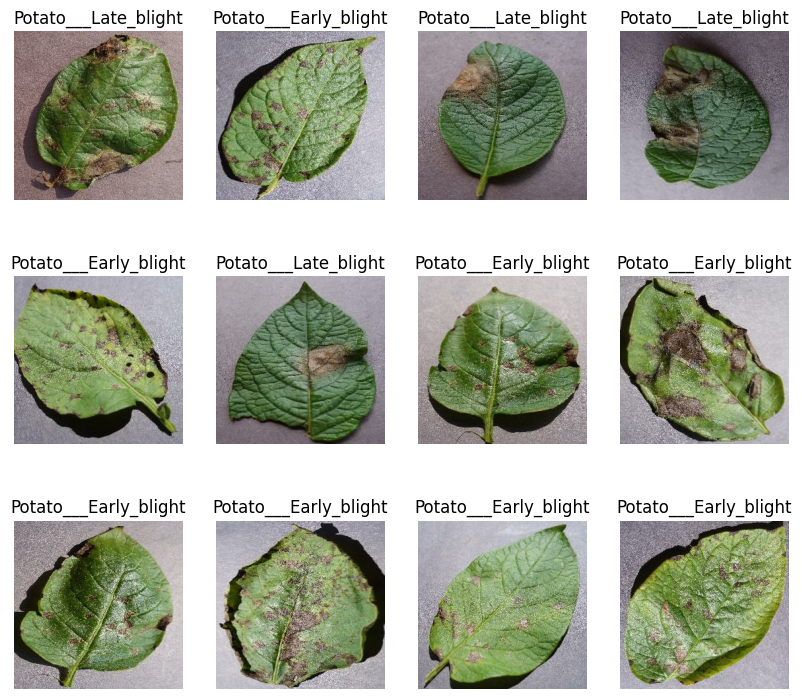

In [7]:
plt.figure(figsize=(10,9))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")

# Train test split 

In [8]:
# training_size = 0.8
# train_ds = dataset.take(54)
# test_ds = dataset.skip(54)

# val_ds = test_ds.take(6)
# test_ds = test_ds.skip(6)

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

# test labels

In [15]:
# import numpy as np
# train_labels_ds = test_ds.map(lambda x, y: y)
# train_labels = np.concatenate(list(train_labels_ds.as_numpy_iterator()))

In [17]:
# train_labels.shape

In [18]:
# test_size = len(test_ds)
# test_labels_ds = test_ds.map(lambda x, y: y)
# test_labels = np.concatenate(list(test_labels_ds.as_numpy_iterator()))

# print(f"Test set size: {test_size}")
# print(f"Test labels size: {len(test_labels)}")

# Optimizitaion of the input pipeline

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing

In [20]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

In [23]:
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=6,
)

Epoch 1/6
54/54 [==============================] - 155s 3s/step - loss: 0.8617 - accuracy: 0.5544 - val_loss: 0.6538 - val_accuracy: 0.7344
Epoch 2/6
54/54 [==============================] - 141s 3s/step - loss: 0.4937 - accuracy: 0.7998 - val_loss: 0.4606 - val_accuracy: 0.8073
Epoch 3/6
54/54 [==============================] - 146s 3s/step - loss: 0.2921 - accuracy: 0.8843 - val_loss: 0.2775 - val_accuracy: 0.8750
Epoch 4/6
54/54 [==============================] - 137s 3s/step - loss: 0.2098 - accuracy: 0.9225 - val_loss: 0.2576 - val_accuracy: 0.8854
Epoch 5/6
54/54 [==============================] - 112s 2s/step - loss: 0.1937 - accuracy: 0.9294 - val_loss: 0.8858 - val_accuracy: 0.6875
Epoch 6/6
54/54 [==============================] - 168s 3s/step - loss: 0.1750 - accuracy: 0.9323 - val_loss: 0.2214 - val_accuracy: 0.8958


In [27]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 9s 738ms/step - loss: 0.2516 - accuracy: 0.8828


[0.25158023834228516, 0.8828125]

In [28]:
history.params

{'verbose': 1, 'epochs': 6, 'steps': 54}

In [29]:
import pandas as pd
df = pd.DataFrame(history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,0.861737,0.554398,0.653827,0.734375
1,0.493717,0.799769,0.460589,0.807292
2,0.292124,0.884259,0.277528,0.875000
3,0.209804,0.922454,0.257616,0.885417
4,0.193684,0.929398,0.885781,0.687500
5,0.174980,0.932292,0.221374,0.895833


<AxesSubplot:>

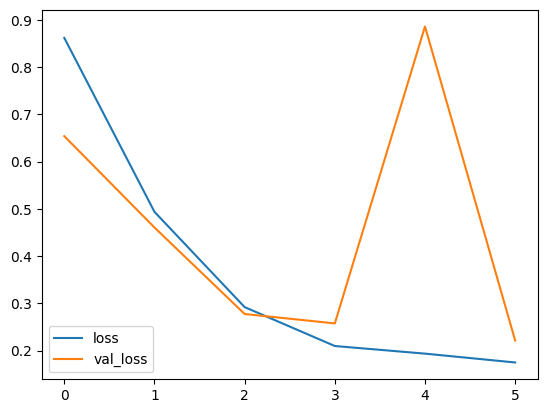

In [30]:
df[['loss','val_loss']].plot()

<AxesSubplot:>

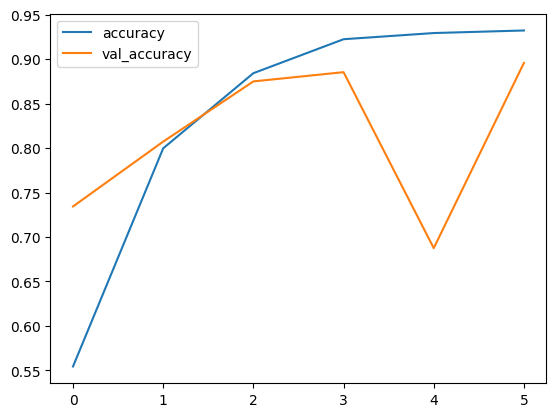

In [31]:
df[['accuracy','val_accuracy']].plot()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


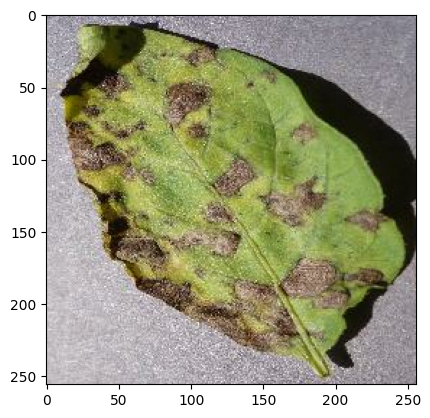

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

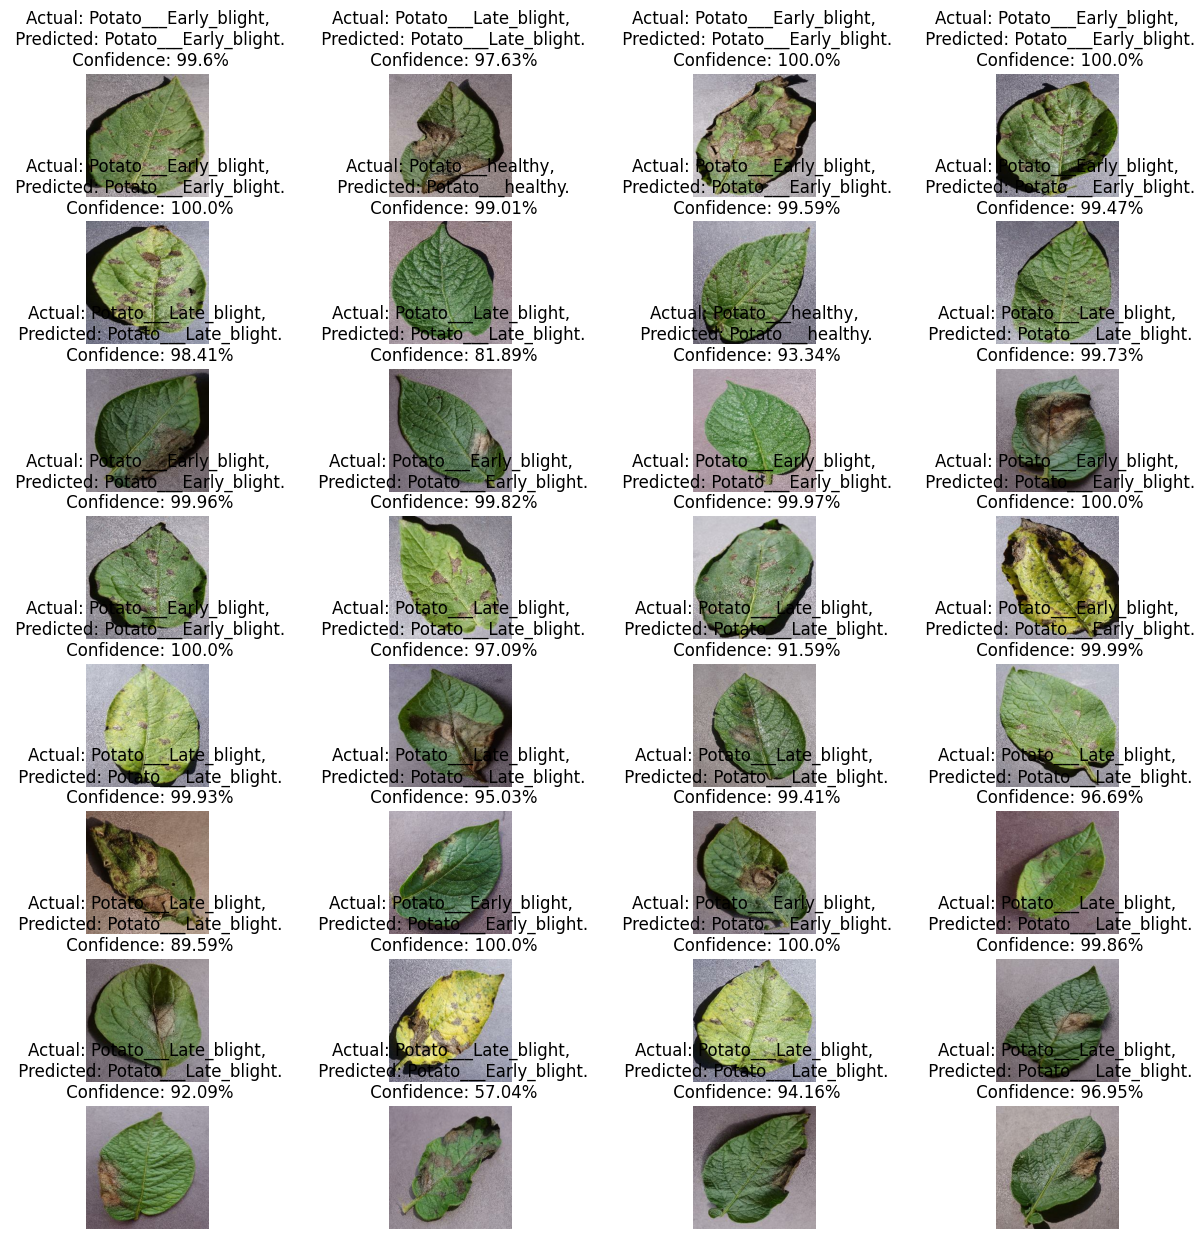

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")